Let's manually backpropagate through in a Multi-Layer Perceptron language model for subreddit names.

This loosely follows part 4 of Andrej Karpathy's excellent [makemore](https://github.com/karpathy/makemore), in particular the [becoming a backprop ninja notebook](https://colab.research.google.com/drive/1WV2oi2fh9XXyldh02wupFQX0wh5ZC-z-?usp=sharing); check that out first. However he used a list of US names, where we're going to use subreddit names

This continues on from [Makemore Subreddits - Part 3 Activations and Gradients](https://skeptric.com/makemore-subreddits-part-3-activation-gradient/), which modularises the Multi-Layer Perceptron following from [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

::: {.callout-note}
This is a Jupyter notebook you can [download the notebook](https://github.com/EdwardJRoss/skeptric/blob/master/makemore-subreddits-part-4-backprop/index.ipynb) if you want to run it yourself.
:::

# Setup

This is the same as in [Part 2](https://skeptric.com/makemore-subreddits-part-2-mlp/)

## Load and filter the data

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import random
import csv
from pathlib import Path
from collections import Counter
from tqdm.auto import trange, tqdm

Filter to subreddits that:

* Have at least 1000 subscribers
* Are not archived
* Are safe for work
* And are not quarantined

Note that you need to have [downloaded subreddits.csv](https://skeptric.com/resources/subreddits.csv.bz2) (and uncompresed if appropriate).

In [2]:
data_path = Path('./data')
min_subscribers = 1_000

with open(data_path / 'subreddits.csv', 'r') as f:
    names = [d['name'] for d in csv.DictReader(f) 
             if int(d['subscribers'] or 0) >= min_subscribers
             and d['description']
             and d['type'] != 'archived'
             and d['nsfw'] == 'f'
             and d['quarantined'] == 'f']
    
len(names)
random.seed(42)
random.shuffle(names)

N = len(names)

names_train = names[:int(0.8*N)]
names_val = names[int(0.8*N):int(0.9*N)]
names_test = names[int(0.9*N):]


for name in names_train[:10]:
    print(name)

len(names_train), len(names_val), len(names_test)

splunk
thenwa
soylent
factorio
christinaricci
blues
vegancheesemaking
goldredditsays
reformed
nagoya


(26876, 3359, 3360)

## Compile the Data

Now convert the dataset into something that the model can easily work with.
First represent all the character tokens as consecutive integers.
We create a special `PAD_CHAR` with index 0 to represent tokens outside of the sequence.

In [3]:
PAD_CHAR = '.'
PAD_IDX = 0

i2s = sorted(set(''.join(names_train)))
assert PAD_CHAR not in i2s
i2s.insert(PAD_IDX, PAD_CHAR)

s2i = {s:i for i, s in enumerate(i2s)}

V = len(i2s)

def compile_dataset(names, block_size, PAD_CHAR=PAD_CHAR, s2i=s2i):
    X, y = [], []
    for name in names:
        padded_name = PAD_CHAR * block_size + name + PAD_CHAR
        padded_tokens = [s2i[c] for c in padded_name]
        for *context, target in zip(*[padded_tokens[i:] for i in range(block_size+1)]):
            X.append(context)
            y.append(target)
    return torch.tensor(X), torch.tensor(y)


block_size = 3

X, y = compile_dataset(names_train, block_size)
X_val, y_val = compile_dataset(names_val, block_size)
X_test, y_test = compile_dataset(names_test, block_size)

X.shape, y.shape

(torch.Size([330143, 3]), torch.Size([330143]))

# Breaking down the MLP

Let's start with an un-parameterised version of the MLP we built in part 3:

In [4]:
from collections import OrderedDict

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

mlp = nn.Sequential(OrderedDict(dict(
    embed = nn.Embedding(V, n_embd),
    flatten = nn.Flatten(),
    hidden = nn.Linear(n_embd * block_size, n_hidden),
    batchnorm = nn.BatchNorm1d(n_hidden),
    activation = nn.Tanh(),
    output = nn.Linear(n_hidden, V),
)))

## Weights and biases

Let's extract all the weights and biases from the model and view their distribtions.

The embedding layer is a a standard normal:

(tensor(0.0527, grad_fn=<MeanBackward0>),
 tensor(0.9875, grad_fn=<StdBackward0>))

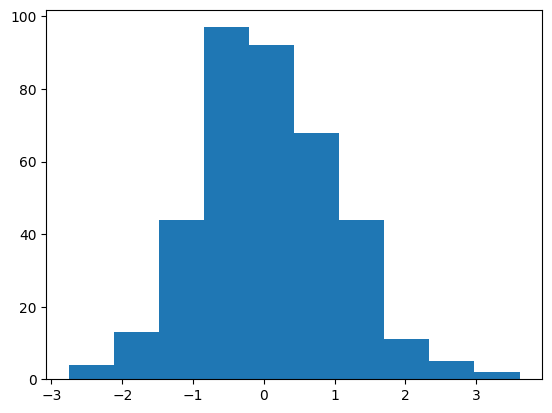

In [5]:
C = mlp.embed.weight
plt.hist(C.flatten().detach().numpy())
C.mean(), C.std()

The linear weights and biases are [documented](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to be uniformly distributed:

$$\mathcal{U}\left(-\frac{1}{\sqrt{\rm in\_features}}, \frac{1}{\sqrt{\rm in\_features}}\right)$$

(Note this is different to what Karpathy does in Makemore using uniform distributions)

And since $$ \mathbb{V}\left[\mathcal{U}(a, b)\right] = \frac{(b - a)^2}{12}$$

we expect the mean to be 0 and the standard deviation to be $\sqrt{\frac{(2/\sqrt{{\rm in\_features}})^2}{12}} = \frac{1}{\sqrt{3 \times {\rm in\_features}}}$.

This appears to be the case for the first weight

(tensor(0.0001, grad_fn=<MeanBackward0>),
 tensor(1.0072, grad_fn=<MulBackward0>))

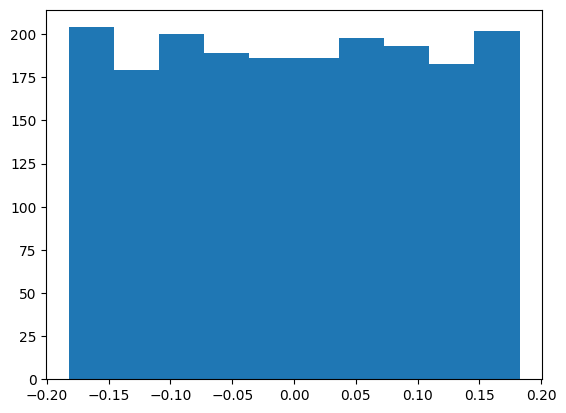

In [6]:
W1 = mlp.hidden.weight.T
plt.hist(W1.flatten().detach().numpy())
W1.mean(), W1.std() * (3 * len(W1))**0.5

And the first bias (which is less clear because there are fewer elements, so the histogram has more error)

(tensor(0.0319, grad_fn=<MeanBackward0>),
 tensor(0.9086, grad_fn=<MulBackward0>))

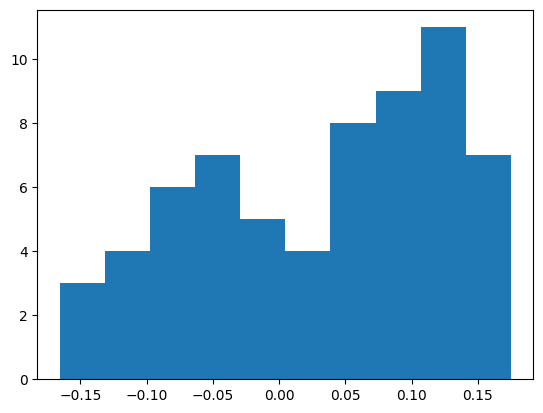

In [7]:
b1 = mlp.hidden.bias
plt.hist(b1.flatten().detach().numpy())
b1.mean(), b1.std() * (3 * len(W1))**0.5

And similarly for the output linear layer weights

(tensor(0.0005, grad_fn=<MeanBackward0>),
 tensor(1.0007, grad_fn=<MulBackward0>))

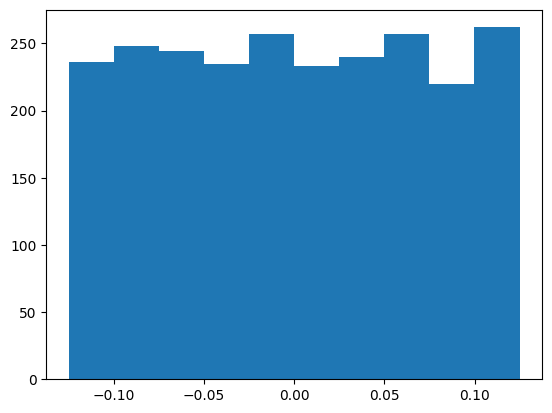

In [8]:
W2 = mlp.output.weight.T
plt.hist(W2.flatten().detach().numpy())
W2.mean(), W2.std() * (3 * len(W2))**0.5

and biases

(tensor(0.0284, grad_fn=<MeanBackward0>),
 tensor(0.9401, grad_fn=<MulBackward0>))

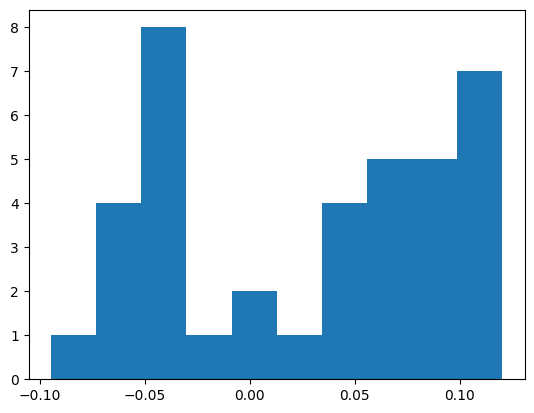

In [9]:
b2 = mlp.output.bias
plt.hist(b2.flatten().detach().numpy())
b2.mean(), b2.std() * (3 * len(W2))**0.5

The batchnorm weights and biases are initialised to 1s and 0s respectively:

In [10]:
mlp.batchnorm.weight, mlp.batchnorm.bias

(Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        requires_grad=True))

We will add some jitter to check that our derivatives work in general and not just for this very special case:

In [11]:
with torch.no_grad():
    mlp.batchnorm.weight += torch.randn_like(mlp.batchnorm.weight) * 0.1
    mlp.batchnorm.bias += torch.randn_like(mlp.batchnorm.bias) * 0.1

bngain = mlp.batchnorm.weight
bnbias = mlp.batchnorm.bias

## Calculating the loss step by step

Let's rewrite our MLP manually in terms of the underlying parameters so we can more clearly see the equations we need to backpropagate.

We'll start off by running a batch of data through the MLP:

In [12]:
batch_size = 32
ix = torch.randint(0, X.shape[0], (batch_size,))
Xb, Yb = X[ix], y[ix]

preds = mlp(Xb)
logloss = F.cross_entropy(input=preds, target=Yb)
logloss

tensor(3.5808, grad_fn=<NllLossBackward0>)

The first step of unpacking the MLP is to run each layer individually, which gives the same result:

In [13]:
mlp

Sequential(
  (embed): Embedding(38, 10)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=30, out_features=64, bias=True)
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): Tanh()
  (output): Linear(in_features=64, out_features=38, bias=True)
)

In [14]:
embed = mlp.embed(Xb)
flatten = mlp.flatten(embed)
hidden = mlp.hidden(flatten)
batchnorm = mlp.batchnorm(hidden)
activation = mlp.activation(batchnorm)
output = mlp.output(activation)

(preds==output).all().item()

True

We can then expand this out into the underlying calculations using the parameters of the layers:

In [15]:
n = batch_size
atol = 1e-7

# Embedding
emb = C[Xb]
assert torch.allclose(embed, emb, atol=atol)
# Flatten
embcat = emb.view(n, -1)
assert torch.allclose(flatten, embcat, atol=atol)
# Hidden layer
hprebn = embcat @ W1 + b1 # (Read: h_pre_bn (batch norm))
assert torch.allclose(hidden, hprebn, atol=atol)
# Batch norm
bnmeani = 1/n * hprebn.sum(dim=0, keepdim=True) # Mean
bndiff = hprebn - bnmeani # Batch Centred
bndiff2 = bndiff ** 2
# N.B. For training Variance estimates we use uncorrected
# This corresponds to Algorithm 1 of the original paper
# https://arxiv.org/pdf/1502.03167.pdf where correction is
# only used at inference time.
# This differs from Karpathy's implementation 
bnvar = 1/n * (bndiff2).sum(0, keepdim=True) # Variance 
bnvar_inv = (bnvar + 1e-5) ** -0.5 # Inverse stddev
bnraw = bndiff * bnvar_inv  # Batch Standardized
hpreact = bngain * bnraw + bnbias
assert torch.allclose(batchnorm, hpreact, atol=atol)
# Activation
h = torch.tanh(hpreact)
assert torch.allclose(activation, h, atol=atol)
# Output logits
logits = h @ W2 + b2
assert torch.allclose(output, logits, atol=atol)

One way to calculate the cross-entropy loss, $- \log \mathcal L$ , from the logits, $z_i$, over the vocabulary of length $V$ is using the formulae:

$$\begin{align}
p_i &= \frac{\exp(z_i)}{\sum_{j=1}^{V}\exp(z_j)} \\
- \log \mathcal L &= \sum_{i=1}^{V} y_i \log(p_i)
\end{align}$$

noting that the $y_i$ here are 1 for the correct token and 0 otherwise, and so if the index of this token is $I$ then $- \log \mathcal L = \log(p_{I})$.

This equation applies to each item in the batch, and we average over the items.

In [16]:
explogits = logits.exp()
probs = explogits / explogits.sum(axis=-1, keepdim=True)
logprobs = probs.log()
# For each item in the batch pick the index where y=1, and average.
loss = -logprobs[range(n), Yb].mean()

assert torch.allclose(logloss, loss, atol=atol)

However this is numerically unstable; in particular if some of the logits are large it may overflow and give the wrong result.

A better option is to use the [log-sum-exp trick](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/) to stabalise the denominator calculation.
This shifts the logits so the maximum exponential is 1.

$$ \begin{align}
\log p_i &= \log\left(\frac{\exp(z_i)}{\sum_{j=1}^{V} \exp(z_j)}\right) \\
    &= z_i - \log \left({\sum_{j=1}^{V} \exp(z_j)}\right) \\
    &= z_i - \log \left({\sum_{j=1}^{V} \exp\left(z_j+\max(z) - \max(z)\right)}\right) \\
    &= z_i - \max(z) -  \log \left({\sum_{j=1}^{V} \exp\left(z_j - \max(z)\right)}\right)
\end{align}$$

In [17]:
logit_maxes = logits.max(axis=-1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)

# Note that here it would be more efficient to work in logarithms:

# log_counts_sum = counts_sum.log()
# logprobs = norm_logits - log_counts_sum

# But we will stay with Karpathy's implementation
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()

# The rest is the same
loss = -logprobs[range(n), Yb].mean()

assert torch.allclose(logloss, loss, atol=atol)

## Rewriting the forward loop

Let's rewrite the forward loop step by step to enable a finegrained backpropagation.

First let's initialise the parameters:

In [18]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP
vocab_size = V

C  = torch.randn((vocab_size, n_embd))
# Layer 1: We will initialize like PyTorch does using uniform
W1 = torch.rand((n_embd * block_size, n_hidden)) * 2/(n_embd * block_size)**0.5 - 1/(n_embd * block_size)**0.5
b1 = torch.rand(n_hidden) *  2/(n_embd * block_size)**0.5 - 1/(n_embd * block_size)**0.5
# Layer 2: We will initialize like PyTorch here too, and not use the output gain reduction
W2 = torch.rand((n_hidden, vocab_size)) * 2/n_hidden**0.5 - 1/n_hidden**0.5
b2 = torch.rand(vocab_size)  * 2/n_hidden**0.5 - 1/n_hidden**0.5
# BatchNorm parameters, adding some jitter as before
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4962


Now we put together the steps previously for a forward pass:

In [19]:
emb = C[Xb]
# Flatten
embcat = emb.view(n, -1)
# Hidden layer
hprebn = embcat @ W1 + b1 # (Read: h_pre_bn (batch norm))
# Batch norm
bnmeani = 1/n * hprebn.sum(dim=0, keepdim=True) # Mean
bndiff = hprebn - bnmeani # Batch Centred
bndiff2 = bndiff ** 2
bnvar = 1/n * (bndiff2).sum(0, keepdim=True) # Variance (no correction, differs from Karpathy)
bnvar_inv = (bnvar + 1e-5) ** -0.5 # Inverse stddev
bnraw = bndiff * bnvar_inv  # Batch Standardized
hpreact = bngain * bnraw + bnbias
# Activation
h = torch.tanh(hpreact)
# Output logits
logits = h @ W2 + b2
logit_maxes = logits.max(axis=-1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

To help check our intermediate results let's use autograd to populate the gradients of each step:

In [20]:
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.6438, grad_fn=<NegBackward0>)

And create a utility function for comparing our gradients to check these gradients:

In [21]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

# Exercise 1: manual backprop

Backprop through the whole thing manually, backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one.

## Index Notation: one weird trick for tensor calculus

Tensor calculus (including matrix and vector calculus) is very difficult for me.
I always forget which matricies to transpose, which vectors are row and column based, and when you look carefully you'll notice in the literature people sometimes silently transpose the gradients to get nicer equations.
The only way I can get tensor calculus consistently right is to reduce it to index notation which reduces it to scalar valued multivariable calculus (a trick tought to me in undergraduate Physics by the [late Dr. Rod Crewther](https://skeptric.com/rod-crewther/)).
So if I want to calculate the derivative of some tensor T with respect to some tensor W, I just need to calculate each component individually 

$$\frac{\partial T_{i_1, \ldots, i_n}}{\partial W_{j_1, \ldots, j_m}}$$

And then it's often trivial to re-write it into a vector notation suitable for vectorised calculations with numpy; but this can also represent calculations that aren't easily vectorised (and can be trivially converted into [einsum](https://pytorch.org/docs/stable/generated/torch.einsum.html)). 

There are only a few special rules to remember for successful calculation:

### Multivariable chain rule

Given functions $f : \mathbb{R}^l \rightarrow \mathbb{R}^m$, $g : \mathbb{R}^n\rightarrow \mathbb{R}^l$, define the composition by $f \circ g := x \mapsto f(g(x)) : \mathbb{R}^n \rightarrow \mathbb{R}^m$.
We can write the functions in terms of their individual components, for example $f(x) = (f_1(x), \ldots, f_m(x))$ where $f_i: \mathbb{R}^l \rightarrow \mathbb{R}$.
Then the chain rule on each component can be written as:

$$\frac{\partial (f \circ g)_i}{\partial x_j} (x) = \sum_{k=1}^{n} \frac{\partial f_i}{\partial g_i} (g(x)) \frac{\partial g_i}{\partial x_j} (x) $$

Writing out the whole chain of $\circ$ compositions for deeply nested functions is very laborious, and so in practice we take a notational shortcut and write $f$ instead of $f \circ g$ with the composition implied by the denominator in the chain rule.
We also drop the arguments $x$, which are again implicit, and simply write

$$\frac{\partial f_i}{\partial x_j} = \sum_{k=1}^{n} \frac{\partial f_i}{\partial g_i} \frac{\partial g_i}{\partial x_j} $$


### Kronecker Delta

Each of the $x_i$ are independent and so $\frac{\partial x_i}{\partial x_j} = \delta_{i,j}$

$$
\delta_{i,j} = \begin{cases}
0 &\text{if } i \neq j,   \\
1 &\text{if } i=j.   \end{cases}
$$

In matrix notation this is simply the identity matrix.
The main calculational rules are that for any tensor $T_{i} \delta_{i,j} = T_{j} \delta_{i,j}$ and $\sum_{i} \delta_{i,j} = 1$, and so in particular $\sum_{i} T_{i} \delta_{i,j} = T_{j} \sum_{i} \delta_{i,j} = T_{j}$.

### Single variable calculus

For all scalar functions we implicitly extend them to vectors by applying them separately to each component.
For example when we write $\log(x)$ for a tensor $x$ we are really saying: $\log(x)_i = \log(x_i)$.
So then for any scalar function $f$

$$\begin{align}
\frac{\partial f_i}{\partial x_j} &= f'(x_i) \frac{\partial x_i}{\partial x_j} \\
                                   &= f'(x_i) \delta_{i,j}
\end{align}$$

The Kronecker Delta (or equivalently identity matrix) on the right makes sense here: there is no dependence across different components since the function has been applied independently.
In matrix notation we can then simply drop the indices.
This is very convenience since most functions (except batch norm) act independently across the batch dimension.

## Softmax

Let's start with calculating the derivative of loss with respect to logprobs:

`loss = -logprobs[range(n), Yb].mean()`

To keep notation simple we will write the loss as $l$, and the batch output $Yb$ as $y$ (which represents here the *index* that is 1), and the batch size as $n$.
Also we'll use greek letters such as $\iota, \kappa, \lambda$ to track batch indices and latin letter such as $i, j, k, l$ to track internal vectors.
In index notation this gives

$$\begin{align}
l  &= -\frac{1}{n} \sum_{\iota=1}^{n} {\rm logprobs}_{\iota, y_\iota} \\
\frac{\partial l}{\partial{\rm logprobs}_{i,j}} & = - \frac{1}{n} \sum_{\iota=1}^{n} \frac{\partial{\rm logprobs}_{\iota, y_\iota}}{\partial{\rm logprobs}_{i,j}}\\
& = - \frac{1}{n} \sum_{\iota=1}^{n} \delta_{i, \iota} \delta_{j, y_\iota} \\
& = -\frac{1}{n} \delta_{j, y_i} \\
\end{align}$$

In matrix notation the Kronecker delta is a $n \times V$ binary matrix with 1 in columns indexed by y.

In [22]:
dlogprobs = -torch.eye(V)[Yb] / n
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


Note that since only one column is non-zero we're going to be doing a *lot* of multiplying by zeros ahead.

For the derivative with respect to the log probabilities we can apply the chain rule and the rule for derivative of logarithms (implicitly applying it to each item in the batch, and each vector of the V dimensional output independently)

`logprobs = probs.log()`

$$\begin{align}
{\rm logprobs}  &= \log \left({\rm probs}\right) \\
\frac{\partial{\rm logprobs}}{\partial{\rm probs}} &=  \frac{1}{\rm probs} \\
\frac{\partial l}{\partial{\rm probs}}  &= \frac{\partial l}{\partial{\rm logprobs}} \frac{1}{\rm probs}
\end{align}$$

In [23]:
dprobs = dlogprobs / probs
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


The next line looks deceptively simple because of broadcasting:

```
probs = counts * counts_sum_inv
```

Here counts is a $n \times V$ matrix, but `counts_sum_inv` is a $n \times 1$ matrix (one value per item in the batch).
You could consider `counts_sum_inv` to be copied `V` times and take it as a Haddamard product, but a simpler way is to view it in index notation (for each item of the batch):

$$ {\rm probs}_{i} = {\rm counts}_{i} \times {\rm counts\_sum\_inv} $$

Which we can write as

$$\begin{align}
\frac{\partial{\rm probs}_{i}}{\partial{\rm  counts\_sum\_inv}} & =  {\rm counts}_{i}\\
\frac{\partial l}{\partial{\rm counts\_sum\_inv}}  &= \sum_{i=1}^{V} \frac{\partial{\rm l}}{\partial{\rm probs}_{i}} \frac{\partial{\rm probs}_{i}}{\partial{\rm  counts\_sum\_inv}} \\
&= \sum_{i=1}^{V}  \frac{\partial{\rm l}}{\partial{\rm probs}_{i}} {\rm counts}_{i}
\end{align}
$$

We can write the last equation in PyTorch (noting the sum is over the last axis) as:

In [24]:
dcounts_sum_inv = (dprobs * counts).sum(axis=-1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


For `counts_sum` the rationale is similar but we need to remember that `counts_sum_inv` also depends on `counts_sum` via the equations:

```
probs = counts * counts_sum_inv
counts_sum_inv = counts_sum**-1
```

so we have in equations:

$$\begin{align}
{\rm probs}_{i} &= {\rm counts}_{i} \times {\rm counts\_sum\_inv} \\
{\rm counts\_sum\_inv} &= {\rm counts\_sum}^{-1} \\
\end{align}$$

and so

$$\begin{align}
\frac{\partial{\rm counts\_sum\_inv}}{\partial{\rm  counts\_sum}} & = \frac{-1}{{{\rm counts\_sum}}^2} \\
%
\frac{\partial{\rm probs}_{i}}{\partial{\rm  counts\_sum}} &= \frac{- {\rm counts}_{i}}{{{\rm counts\_sum}}^2} \\
%
\frac{\partial l}{\partial{\rm counts\_sum}}  &= \sum_{i=1}^{V} \frac{\partial l}{\partial{\rm probs}_{i}} \frac{\partial{\rm probs}_{i}}{\partial{\rm  counts\_sum}} \\
&= \frac{-1}{{\rm counts\_sum}^2} \sum_{i=1}^{V}  \frac{\partial l}{\partial{\rm probs}_{i}} {\rm counts}_{i}  \\
\end{align}
$$


Which can be written as:

In [25]:
dcounts_sum = (-1 / (counts_sum**2)) * (dprobs * counts).sum(axis=-1, keepdim=True)
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


Now `counts` comes in two places: through `probs` and `counts_sum` (via `counts_sum_inv`):

```
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
```

$$\begin{align}
{\rm counts\_sum} &= \sum_{i=1}^{V} {\rm counts}_{i}\\
\frac{\partial l}{\partial{\rm counts}_{j}}  &= 
   \frac{\partial l}{\partial{\rm counts\_sum}}
   \frac{\partial {\rm counts\_sum}}{\partial{\rm counts}_{j}} + 
   \sum_{i=1}^{V}
   \frac{\partial l}{\partial{\rm probs}_{i}}
   \frac{\partial {\rm probs}_{i}}{\partial{\rm counts}_{j}} \\
   &= \frac{\partial l}{\partial{\rm counts\_sum}} 
   \sum_{i=1}^{V} \delta_{i,j} +
 \sum_{i=1}^{V} 
   \frac{\partial l}{\partial{\rm probs}_{i}}
   \delta_{i,j} {\rm counts\_sum\_inv}
   \\
   &=  \frac{\partial l}{\partial{\rm counts\_sum}} +
   \frac{\partial l}{\partial{\rm probs}_{j}}  {\rm counts\_sum\_inv}
   \\
\end{align}$$

Note we're being a little sloppy here in our functional notation, and in particular in the second term we are not explicitly considering `count_sum_inv` as a function of `counts` since we account for this dependency in the first term.


Using broadcasting on the first term we can write this in PyTorch as:

In [26]:
dcounts = dcounts_sum + dprobs * counts_sum_inv
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


Next for `norm_logits` we can use that the derivative of an exponential is itself:

```
counts = norm_logits.exp()
```

In [27]:
dnorm_logits = dcounts * counts
cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


For `logits_maxes` the formula looks simple, but again some complexity is hidden by broadcasting:

```
# (n, V)      (n, V)      (n, 1)       
norm_logits = logits - logit_maxes
```

Again it becomes clearer in index notation:

$$\begin{align}
{\rm norm\_logits}_{i} &= {\rm logits}_{i} - {\rm logit\_maxes} \\
\frac{\partial l}{\partial {\rm logit\_maxes}} &= 
    \sum_{i=1}^{V}
    \frac{\partial l}{\partial {\rm norm\_logits}_{i}} 
    \frac{\partial {\rm norm\_logits}_{i}}{\partial {\rm logit\_maxes}} \\
    &=
    \sum_{i=1}^{V}
    \frac{\partial l}{\partial {\rm norm\_logits}_{i}} 
    (-1) \\
    &=  -\sum_{i=1}^{V} \frac{\partial l}{\partial {\rm norm\_logits}_{i}} 
\end{align}$$

Or in code:

In [28]:
dlogit_maxes = -dnorm_logits.sum(axis=1, keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


For `logits` it also appears in two places:

```
logit_maxes = logits.max(axis=-1, keepdim=True).values
norm_logits = logits - logit_maxes
```

The `max` function is differentiable almost everywhere with derivative 1 for the maximum variable and 0 otherwise, with point discontinuities where the function is not differentiable; we'll assume we're not at a discontinuity:

$\begin{align}
\frac{\partial {\rm norm\_logits}_{i}}{\partial {\rm logits}_{j}}  &= \delta_{i,j} \\
\frac{\partial {\rm logit\_maxes}}{\partial {\rm logits}_{j}}  &= \delta_{j, {\operatorname{argmax}(\rm logits)}}\\
\frac{\partial l}{\partial {\rm logits}_{j}} &= 
    \sum_{i=1}^{V}
    \frac{\partial l}{\partial {\rm norm\_logits}_{i}} 
     \frac{\partial {\rm norm\_logits}_{i}}{\partial {\rm logits}_{j}} +
     \frac{\partial l}{\partial {\rm logit\_maxes}} \frac{\partial {\rm logit\_maxes}}{\partial {\rm logits}_{j}}
\\
&=  \frac{\partial l}{\partial {\rm norm\_logits}_{j}} +  \frac{\partial l}{\partial {\rm logit\_maxes}} \delta_{j, {\operatorname{argmax}(\rm logits)}} 
\end{align}$

So we simply add the functions converting the Kronecker Delta into an identity matrix

In [29]:
dlogits = dnorm_logits + dlogit_maxes * torch.eye(V)[logits.argmax(axis=-1)]
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


Using the identity matrix means we're adding a lot of 0's which is wasted cycles, a better approach is to explicitly mutate the non-zero values:

In [30]:
dlogits = dnorm_logits.clone()
dlogits[range(n), logits.argmax(axis=-1)] += dlogit_maxes.flatten()
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


## Linear Output Layer

We're finally through the softmax into the linear layer::

```
logits = h @ W2 + b2
```

$$\begin{align}
{\rm logits}_{i} &= \sum_{k} h_{k} W_{k, i} + b_i \\
\frac{\partial {\rm logits}_{i}}{\partial h_{j}} & = \sum_{k}  \delta_{j,k} W_{k,i} \\
&= W_{j, i} \\
\frac{\partial l}{\partial h_{j}} & = \sum_{i} \frac{\partial l}{\partial {\rm logits}_{i}} \frac{\partial {\rm logits}_{i}}{\partial h_{j}} \\
&= \sum_{i}  \frac{\partial l}{\partial {\rm logits}_{j}} W_{j, i} \\
&= \frac{\partial l}{\partial {\rm logits}} W^T \\
\end{align}$$

The final term is a vector-matrix product:

In [31]:
dh = dlogits @ W2.T
cmp('h', dh, h)

h               | exact: True  | approximate: True  | maxdiff: 0.0


Since the weight term does not have a batch dimension we need to consider the minibatch index too during backpropagation (we can't just implicitly transfer across it):

$$\begin{align}
{\rm logits}_{\lambda, i} &= \sum_{k} h_{\lambda, k} W_{k, i} + b_i \\
\frac{\partial {\rm logits}_{\lambda, i}}{\partial W_{j,k}} & = \sum_{l} h_{\lambda, l} \delta_{j,l} \delta_{k,i}  \\
&= \delta_{i,k} h_{\lambda, j} \\
\frac{\partial l}{\partial W_{j,k}} & = \sum_{\lambda=1}^{n} \sum_{i} \frac{\partial l}{\partial {\rm logits}_{\lambda, i}} \frac{\partial {\rm logits}_{\lambda, i}}{\partial W_{j,k}} \\
 & = \sum_{\lambda=1}^{n}  \frac{\partial l}{\partial {\rm logits}_{\lambda, i}} h_{\lambda, j} \\
 &= h^T  \frac{\partial l}{\partial {\rm logits}}
\end{align}$$

The final term being a matrix-matrix product across the batch dimension (we accumulate the gradients across the batch):

In [32]:
dW2 =  h.T @ dlogits
cmp('W2', dW2, W2)

W2              | exact: True  | approximate: True  | maxdiff: 0.0


Similarly we need to account for the minibatch dimension in the bias term:

$$\begin{align}
\frac{\partial {\rm logits}_{\lambda, i}}{\partial b_{j}} & = \delta_{i,j} \\
\frac{\partial l}{\partial b_{j}} & =\sum_{\lambda=1}^{n}\sum_{i} \frac{\partial l}{\partial {\rm logits}_{\lambda, i}} \frac{\partial {\rm logits}_{i}}{\partial b_{j}} \\
                                  &= \sum_{\lambda=1}^{n} \frac{\partial l}{\partial {\rm logits}_{\lambda, j}} \\
\end{align}$$

So we simply add the gradients for the biases (note that we can consider this a special case of the weight matrix equation where $h$ is a vector of ones giving $1^T \frac{\partial l}{\partial {\rm logits}}$):

In [33]:
db2 = dlogits.sum(axis=0, keepdim=True)
cmp('b2', db2, b2)

b2              | exact: True  | approximate: True  | maxdiff: 0.0


## Activation

The activation follows immediately from the derivative of $\tanh$:

```
h = torch.tanh(hpreact)
```

$$\begin{align}
\frac{\partial h}{\partial {\rm hpreact}} &= 1 - \tanh({\rm hpreact})^2\\
                                          &= 1 - h^2 \\
\end{align}$$

In [34]:
dhpreact =   dh * ((1.0 - h*h))

cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: False | approximate: True  | maxdiff: 2.3283064365386963e-10


It appears there is some approximation of the derivative in torch for larger values, but I can't work out what it is:

'Equal for input < 0.244'

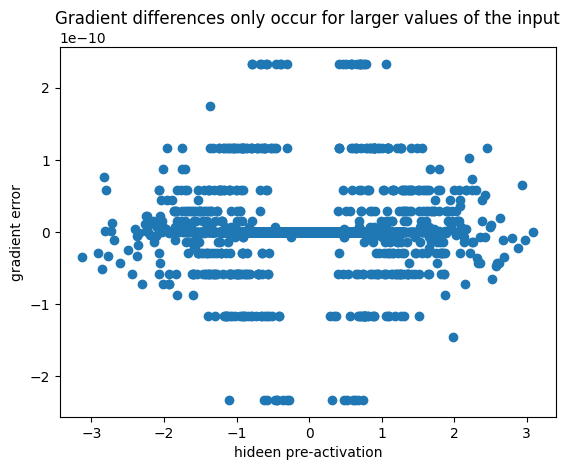

In [35]:
error = (hpreact.grad - dhpreact).flatten().detach()
plt.scatter(hpreact.flatten().detach(), error)
plt.xlabel('hideen pre-activation')
plt.ylabel('gradient error')
plt.title('Gradient differences only occur for larger values of the input')

f'Equal for input < {hpreact.flatten()[error != 0].abs().min().item():0.3f}'

To check downstream gradients exactly we'll use PyTorch's gradient:

In [36]:
dhpreact = hpreact.grad

## Batchnorm

The is a simple affine transformation and is the same as the linear case:

```
hpreact = bngain * bnraw + bnbias
```

We have to accumulate over the `bngain` and `bnbias` which don't have a batch dimension:

In [37]:
dbngain = (dhpreact * bnraw).sum(axis=0, keepdim=True)
cmp('bngain', dbngain, bngain)
dbnbias = dhpreact.sum(axis=0, keepdim=True)
cmp('bnbias', dbnbias, bnbias)
dbnraw = dhpreact * bngain
cmp('bnraw', dbnraw, bnraw)

bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0


Standardising is another linear transformation:

```
bnraw = bndiff * bnvar_inv  # Batch Standardized
```

In [38]:
dbnvar_inv = (bndiff * dbnraw).sum(axis=0, keepdim=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

bnvar_inv       | exact: True  | approximate: True  | maxdiff: 0.0


We can calculate the derivative `bnvar_inv` using simple single-variable calculus

```
bnvar_inv = (bnvar + 1e-5) ** -0.5 # Inverse stddev
```

$$\begin{align}
{\rm bnvar\_inv} &= \left({\rm bnvar} + 10^{-5}\right)^{-1/2} \\
\frac{\partial {\rm bnvar\_inv}}{\partial {\rm bnvar}} &= -\frac{1}{2}\left({\rm bnvar} + 10^{-5}\right)^{-3/2} \\
\end{align}$$

In [39]:
dbnvar = dbnvar_inv * (-0.5 * (bnvar + 1e-5)**-1.5) 
cmp('bnvar', dbnvar, bnvar)

bnvar           | exact: True  | approximate: True  | maxdiff: 0.0


The variance is straightforward using the derivative of a sum:

bnvar = 1/n * (bndiff2).sum(0, keepdim=True) # Variance (no correction, differs from Karpathy)

In [40]:
dbndiff2 = dbnvar / n
cmp('bndiff2', dbndiff2, bndiff2)

bndiff2         | exact: True  | approximate: True  | maxdiff: 0.0


For `bndiff` we have to be careful to use both places it impacts the output:

```
bndiff2 = bndiff ** 2
bnraw = bndiff * bnvar_inv 
```

In [41]:
dbndiff = (2 * bndiff) * dbndiff2 + dbnraw * bnvar_inv
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact: True  | approximate: True  | maxdiff: 0.0


For `bnmeani` we need to sum over the batch dimension to handle the implicit broadcasting:

```
bndiff = hprebn - bnmeani # Batch Centred
```

In [42]:
dbnmeani = - dbndiff.sum(axis=0)
cmp('bnmeani', dbnmeani, bnmeani)

bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0


For `hprebn` we need to account for it coming into both calculating the mean and for the centring:

```
bnmeani = 1/n * hprebn.sum(dim=0, keepdim=True) # Mean
bndiff = hprebn - bnmeani # Batch Centred
```

In [43]:
dhprebn = dbnmeani * (1/n) + dbndiff
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: True  | approximate: True  | maxdiff: 0.0


## Hidden linear layer

The first hidden layer follows the exact same calculus as the output hidden layer

```
hprebn = embcat @ W1 + b1
```

In [44]:
dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)
dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)
db1 = dhprebn.sum(axis=0)
cmp('b1', db1, b1)

embcat          | exact: True  | approximate: True  | maxdiff: 0.0
W1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


## Concatenation layer

The concatenation layer just reshapes the input, and so the derivative just gets reshaped backwards:

```
(n, h*s)   (n, h, s)
embcat = emb.view(n, -1)
```

In [45]:
emb.shape, dembcat.shape

(torch.Size([32, 3, 10]), torch.Size([32, 30]))

In [46]:
demb = dembcat.view(n, block_size, n_embd)
cmp('emb', demb, emb)

emb             | exact: True  | approximate: True  | maxdiff: 0.0


## Embedding Layer

The embedding layer is a simple lookup of the indices

```
emb = C[Xb]
```

This can be seen as an optimisation of the matrix multiplication of the one-hot encoding:

In [47]:
((torch.eye(V)[Xb] @ C) == C[Xb]).all().item()

True

We could then use a matrix derivative to accumulate over the batch (and implicitly over the block):

In [48]:
dC = torch.eye(V)[Xb].view(n * block_size, V).T @  demb.view(n*block_size, n_embd)
cmp('C', dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


However this has a lot of multiplication by zero and so may be very inefficient

In [49]:
f'{(torch.eye(V)[Xb] == 0).sum() / len((torch.eye(V)[Xb]).flatten()):0.2%} of the values are zero'

'97.37% of the values are zero'

Really we just want to add `demb` to `C` for each of the indices in `Xb`.
Ideally we could do it like this:

In [50]:
dC = torch.zeros_like(C)
dC[Xb] += demb
cmp('C', dC, C)

C               | exact: False | approximate: False | maxdiff: 0.014890540391206741


But it doesn't work because internally the update is only applied to the original value, not iteratively (seel [numpy's explanation](https://numpy.org/doc/stable/user/basics.indexing.html#assigning-values-to-indexed-arrays)).

Instead Torch provides a function [`index_add_`](https://pytorch.org/docs/stable/generated/torch.Tensor.index_add_.html) that can do this correctly:

In [51]:
dC = torch.zeros_like(C).index_add_(0, index=Xb.flatten(), source=demb.view(n*block_size, n_embd))
cmp('C', dC, C)

C               | exact: True  | approximate: True  | maxdiff: 0.0


# Exercise 2: Backprop through cross entropy

Backprop through cross_entropy but all in one go.
To complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out

In [52]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.643820285797119 diff: 4.76837158203125e-07


In the simple case of a minibatch with 1 item (note here we're referring to $y_i$ as the 1-hot encoded vector, rather than the vector of 1-indices):

$$\begin{align}
l &= - \sum_{i=1}^{n} y_i \log p_i \\
p_i &= \frac{\exp(z_i)}{\sum_{j=1}^{n} \exp(z_j)} \\
\log p_i &= z_i - \log \left(\sum_{j=1}^{n} \exp(z_j)\right) \\
\frac{\partial \log p_i}{\partial z_k} &=  \delta_{i,k} - \frac{\exp(z_k)}{\sum_{j=1}^{n} \exp(z_j)} = \delta_{i,j} - p_k \\
\frac{\partial l}{\partial z_k} &= p_k \left(\sum_{i=1}^{n} y_i\right) - y_k \\
\frac{\partial l}{\partial z_k} &= p_k - y_k
\end{align}$$

When we have multiple items we average the loss across the minibatch:

$$\begin{align}
l &= - \frac{1}{n}\sum_{\lambda=1}^{n} y_{\lambda,i} \log p_{\lambda, i} \\
\frac{\partial l}{\partial z_k} &= \frac{1}{n}\sum_{\lambda=1}^{n} p_{\lambda, k} - y_{\lambda, k}
\end{align}
$$

We can calculate this by first calculating $p/n$ and then subtracting $1/n$ from the index of the target token:

In [53]:
exp_norm_logits = logits.exp()
probs = exp_norm_logits / exp_norm_logits.sum(axis=1, keepdim=True)
dlogits = probs.clone()/n 
dlogits[range(n), Yb] -= 1/n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


A more numerically stable way to calculate the probabilities is to subtract the maximum value:

$$p_i = \frac{\exp z_i}{\sum_{j=1}^{V} \exp z_j} = \frac{\exp(z_i - \max(z))}{\sum_{j=1}^{V} \exp(z_j - \max(z))}$$

In [54]:
exp_norm_logits = (logits - logits.max(axis=1, keepdim=True).values).exp()
probs = exp_norm_logits / exp_norm_logits.sum(axis=1, keepdim=True)
dlogits = probs.clone()/n 
dlogits[range(n), Yb] -= 1/n

cmp('logits', dlogits, logits) # I can only get approximate to be true

logits          | exact: False | approximate: True  | maxdiff: 5.704350769519806e-09


Or we could just directly use PyTorch's softmax function:

In [55]:
dlogits = F.softmax(logits, dim=-1)/n 
dlogits[range(n), Yb] -= 1/n

cmp('logits', dlogits, logits) # I can only get approximate to be true

logits          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


# Exercise 3: Backprop through batchnorm

Backprop through batchnorm but all in one go.
To complete this challenge look at the mathematical expression of the output of batchnorm,  take the derivative w.r.t. its input, simplify the expression, and just write it out.

In [56]:
# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(0.0507, grad_fn=<MaxBackward1>)


From the [BatchNorm paper](https://arxiv.org/abs/1502.03167) we have (using $n$ as in our notation)

$$\begin{align}
\mu(x) &= \frac{1}{n} \sum_{\lambda=1}^{n} x_i \\
\sigma^2(x) &= \frac{1}{n} \sum_{\lambda=1}^{n} (x - \mu(x))^2 \\
\hat{x}_i &= \frac{x_i - \mu(x)}{\sqrt{\sigma^2(x) + \epsilon}} \\
\operatorname{BN}(x)_i &= \gamma \hat{x}_i + \beta \\
\end{align}$$


Note that here $i$ is the batch index, and this applied across all the components of each x in the batch (which have independent $\gamma$ and $\beta$).
Then we can rederive the derivatives across the batch dimension as in the paper:

$$\begin{align}
\frac{\partial \mu}{\partial x_\kappa} &= \frac{1}{n} \sum_{\lambda=1}^{n} \delta_{\lambda,\kappa} = \frac{1}{n} \\
\frac{\partial \sigma^2}{\partial x_\kappa} &= \frac{1}{n} \sum_{\lambda=1}^n 2 \left(x_\lambda - \mu(x)\right) \left(\delta_{\lambda,\kappa} - \frac{1}{n}\right) \\
                                       &= \frac{2}{n} \sum_{\lambda=1}^n \left(x_\lambda - \mu(x)\right) \delta_{\lambda,\kappa} -  \frac{2}{n^2} \sum_{\lambda=1}^n \left(x_\lambda - \mu(x)\right) \\
                                       &= \frac{2}{n} \left(x_\kappa - \mu(x)\right) - 0 \\
                                       &= \frac{2}{n}(x_\kappa - \mu(x)) \\
\frac{\partial \operatorname{BN}_\lambda}{\partial x_\kappa} &= \gamma \left(\frac{\delta_{\lambda,\kappa} - 1/n}{\sqrt{\sigma^2(x) + \epsilon}} - \frac{1}{2} \frac{x_\lambda - \mu(x)}{\left(\sigma^2(x) + \epsilon\right)^{3/2}} \frac{2}{n} \left(x_\kappa - \mu(x)\right)\right) \\
&= \frac{\gamma}{\sqrt{\sigma^2(x) + \epsilon}} \left( \delta_{\lambda,\kappa} - \frac{1}{n} - \frac{1}{n} \hat{x}_\lambda \hat{x}_\kappa \right) \\
\frac{\partial l}{\partial x_\kappa} &= \sum_{\lambda=1}^{n} \frac{\partial l}{\operatorname{BN}_\lambda} \frac{\partial \operatorname{BN}_\lambda}{\partial x_\kappa} \\
                                &=  \frac{\gamma}{\sqrt{\sigma^2(x) + \epsilon}} \left( \frac{\partial l}{\partial  \operatorname{BN}_\kappa} 
                                  - \frac{1}{n} \sum_{\lambda=1}^{n}\frac{\partial l}{\partial  \operatorname{BN}_\lambda}  
                                  - \frac{1}{n}\hat{x}_\kappa \left(\sum_{\lambda=1}^{n} \hat{x}_\lambda \frac{\partial l}{\partial  \operatorname{BN}_\lambda}  \right)
                                  \right) \\
\end{align}$$

Note that the first two terms of the final line represent the deviation of the gradient with respect to its mean over the batch, and the final term corresponds to a second moment with the *standardised* input $\hat{x}$.

In [57]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# Forward pass variables
bnmeani = 1/n * hprebn.sum(dim=0, keepdim=True)        # μ
bndiff = hprebn - bnmeani                              # x - μ
bnvar2 = 1/n * (bndiff ** 2).sum(0, keepdim=True)      # σ²
bnvar_inv = (bnvar + 1e-5)**-0.5                       # 1/√(σ² + ε)
bnraw = bndiff * bnvar_inv                             # x_hat
# Derivative:
# dl/dx   =    γ     1/√(σ² + ε)    dl/dBN              Σ(dl/dBN)                              x^      ( dl/dBN .   x^                          )
dhprebn   = bngain * bnvar_inv * ( dhpreact - 1/n * dhpreact.sum(dim=0, keepdim=True) - 1/n * bnraw * (dhpreact * bnraw).sum(dim=0, keepdim=True) )
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true

hprebn          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09


# Exercise 4: Putting it all together

Train the MLP neural net with your own backward pass

## Setup

In [84]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
vocab_size = V

C  = torch.randn((vocab_size, n_embd))
# Layer 1: We will initialize like PyTorch does using uniform
W1 = torch.rand((n_embd * block_size, n_hidden)) * 2/(n_embd * block_size)**0.5 - 1/(n_embd * block_size)**0.5
b1 = torch.rand(n_hidden) *  2/(n_embd * block_size)**0.5 - 1/(n_embd * block_size)**0.5
# Layer 2: We will initialize like PyTorch here too, and not use the output gain reduction
W2 = torch.rand((n_hidden, vocab_size)) * 2/n_hidden**0.5 - 1/n_hidden**0.5
b2 = torch.rand(vocab_size)  * 2/n_hidden**0.5 - 1/n_hidden**0.5
# BatchNorm parameters, adding some jitter as before
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameter_names = ['C', 'W1', 'b1', 'W2', 'b2', 'bngain', 'bnbias']

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

14618


Let's modify our training loop from part 3 to make a hackable version for calculating our own gradients:

In [59]:
val_step = 10_000
batch_size = 32


def train(#model,
          backward_pass, # new
          n_step, lr, batch_size=batch_size, val_step=val_step, X=X, y=y, X_val=X_val, y_val=y_val, generator=None):
    losses, val_losses = [], []
    
    for step in trange(n_step):
        idx = torch.randint(0, len(X), (batch_size,), generator=generator)
        Xb = X[idx]
        Yb = y[idx]

        # Forward pass
        # Before:
        # logits = model(X[idx])
        # Now:
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=False)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer

        loss =  F.cross_entropy(input=logits, target=Yb)
        losses.append((step, loss.item()))

        # Calculate grad:
        # Before:
        # model.zero_grad()
        # logits = model(X[idx])
        # loss.backward()
        # Now:
        grads = backward_pass(**locals())

        
        for (p, grad) in zip(parameters, grads):
            p.data -= grad * lr(step, n_step)
        
        if step % val_step == 0:
            # Instead of doing validation (which requires tracking the running batch parameters)
            # let's just print our the current loss
            print(f'{step:7d}/{n_step:7d}: {loss.item():.4f}')

    return losses

## Using PyTorch Autograd

We can use PyTorch Autograd and check the loss actually decreases after a couple of steps.

In [60]:
def torch_backward(loss, **kwargs):
    for p in parameters:
        p.grad = None
    loss.backward()
    return [p.grad for p in parameters]

In [61]:
train(torch_backward, n_step = 100, lr = lambda step, n_step: 0.1, val_step=10);

  0%|          | 0/100 [00:00<?, ?it/s]

      0/    100: 3.7021
     10/    100: 3.6256
     20/    100: 3.4283
     30/    100: 3.4369
     40/    100: 3.3651
     50/    100: 3.1933
     60/    100: 3.1444
     70/    100: 3.1995
     80/    100: 3.1755
     90/    100: 3.1842


Now to check our gradients let's run a single step with lr=0 and a fixed batch

In [62]:
train(torch_backward, n_step = 1, lr = lambda step, n_step: 0.0, generator = torch.Generator().manual_seed(2147483647))

  0%|          | 0/1 [00:00<?, ?it/s]

      0/      1: 3.0990


[(0, 3.099048614501953)]

## Solution - Manual Backprop

Now we can test our manual backprop; we'll track the grads so we can test them against PyTorch:

In [63]:
track_grads = []

class ManualGrad:
    def __init__(self):
        self.grads = None
        
    def __call__(self, batch_size, logits, Yb, h, bnraw, bnvar_inv, embcat, Xb, **kwargs):
      n = batch_size
    
      # Loss function
      dlogits =  F.softmax(input=logits, dim=-1)/n 
      dlogits[range(n), Yb] -= 1/n
      # Output linear layer
      dW2 = h.T @ dlogits
      db2 = dlogits.sum(axis=0)
      dh = dlogits @ W2.T
      # Non-linearity
      dhpreact = (1 - h*h) * dh
      # Batch norm
      dbngain = (dhpreact * bnraw).sum(axis=0)
      dbnbias = dhpreact.sum(axis=0)
      dhprebn   = bngain * bnvar_inv * ( dhpreact - 1/n * dhpreact.sum(dim=0, keepdim=True) - 1/n * bnraw * (dhpreact * bnraw).sum(dim=0, keepdim=True))
      # Linear
      dW1 = embcat.T @ dhprebn
      db1 = dhprebn.sum(axis=0)
      dembcat = dhprebn @ W1.T
      dC = torch.zeros_like(C).index_add_(0, index=Xb.flatten(), source=dembcat.view(n*block_size, n_embd))

      self.grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
      return self.grads

In [64]:
manual_grad = ManualGrad()
train(manual_grad, n_step = 1, lr = lambda step, n_step: 0.0, generator = torch.Generator().manual_seed(2147483647))

  0%|          | 0/1 [00:00<?, ?it/s]

      0/      1: 3.0990


[(0, 3.099048614501953)]

And we can check they are all approximately right:

In [65]:
for name, param, grad in zip(parameter_names, parameters, manual_grad.grads):
    cmp(name, grad, param)

C               | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
W1              | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
b1              | exact: False | approximate: False | maxdiff: 1.30385160446167e-08
W2              | exact: False | approximate: True  | maxdiff: 4.470348358154297e-08
b2              | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
bngain          | exact: False | approximate: True  | maxdiff: 1.3969838619232178e-09
bnbias          | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09


## Training without autograd

Then we can run the training manually without using autograd:

In [66]:
with torch.no_grad():
    losses = train(backward_pass = manual_grad,
                   n_step = 200_000,
                   lr = lambda step, n_step: 0.1 if (step/n_step) < 0.5 else 0.01)

plt.plot(*zip(*losses));

  0%|          | 0/200000 [00:00<?, ?it/s]

      0/ 200000: 3.1999
  10000/ 200000: 2.7294
  20000/ 200000: 3.0627
  30000/ 200000: 2.3467
  40000/ 200000: 2.5901
  50000/ 200000: 2.9478
  60000/ 200000: 2.5997
  70000/ 200000: 2.0730
  80000/ 200000: 2.2726
  90000/ 200000: 2.3465
 100000/ 200000: 2.6331
 110000/ 200000: 2.4014
 120000/ 200000: 2.2594
 130000/ 200000: 2.3476
 140000/ 200000: 2.2705
 150000/ 200000: 2.0541
 160000/ 200000: 2.4087
 170000/ 200000: 2.3144
 180000/ 200000: 2.2314
 190000/ 200000: 2.7102


The training loss curve is a bit hard to read, it's easier to see if we run an exponential moving average to smooth the curve:

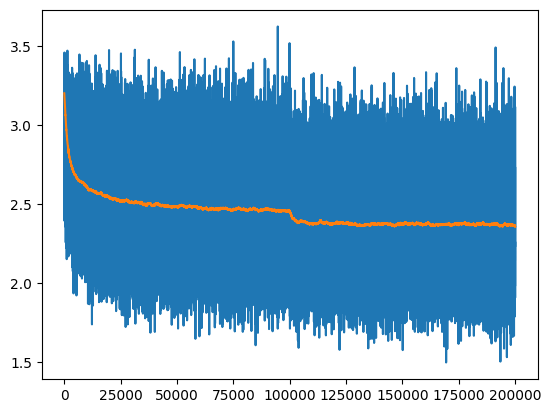

In [77]:
ema = [losses[0][1]]
momentum = 0.999
for idx, loss in losses:
    ema.append(ema[-1] * momentum + loss * (1-momentum))
plt.plot(*zip(*losses));
plt.plot(ema);

Calibrate the batch norm at the end of training

In [79]:
with torch.no_grad():
  # pass the training set through
  emb = C[X]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

## Evaluation

The training and validation loss are similar to what we got in Part 3:

In [81]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  xi,yi = {
    'train': (X, y),
    'val': (X_val, y_val),
    'test': (X_test, y_test),
  }[split]
  emb = C[xi] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, yi)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.327211380004883
val 2.3709540367126465


Finally we can sample from the model to get things that look slightly like subreddit names but go on too long:

In [83]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(i2s[i] for i in out))

ure.
careeleftopentingpars.
pationaider.
thewookyingcrumorbyatkethell.
reaglees.
rhade.
canaryzunnygijoilindisburgernunivestorofthegametoxuceon.
sapers.
videleblutechiviehcies.
sthehomemes.
hebeing.
pap.
walpwerinei.
gingua.
vanstrure.
ballyx.
borianlinterun.
blegg.
liveltholitterangordax.
parkusraediroikibs.


# What next?

This has shown that we can derive the gradients by hand, although I'm not sure we would actually want to do it.
However it is informative to look at the gradients, and I think it would be interesting to reflect on RNNs (which have the recursive explosion) and attention in Transformers.
All of this is to say we should start looking past MLP into more complex models.